Importing libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

Data Preparation and Preprocessing

In [5]:
import os
import cv2
import numpy as np

labels = {'PNEUMONIA': 0, 'NORMAL': 1}  # Using dictionary for clarity
img_size = 224

def get_training_data(data_dir):
    images = [] 
    labels_list = []
    for label, label_num in labels.items(): 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))  # Load image without converting to grayscale
                img_arr = cv2.resize(img_arr, (224, 224))     # Resize image to (224, 224)
                images.append(img_arr)
                labels_list.append(label_num)
            except Exception as e:
                print(e)
    return np.array(images), np.array(labels_list)

In [6]:
train_images, train_labels = get_training_data(r"C:/Users/Dell/Desktop/Pneu_dataset/chest_xray/train")
test_images, test_labels = get_training_data(r"C:/Users/Dell/Desktop/Pneu_dataset/chest_xray/test")
val_images, val_labels = get_training_data(r"C:/Users/Dell/Desktop/Pneu_dataset/chest_xray/val")


In [7]:
pnenumonia = 0 
normal = 0 

for label in train_labels:
    if label == 0:
        pnenumonia += 1
    else:
        normal += 1

print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia - normal)


Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


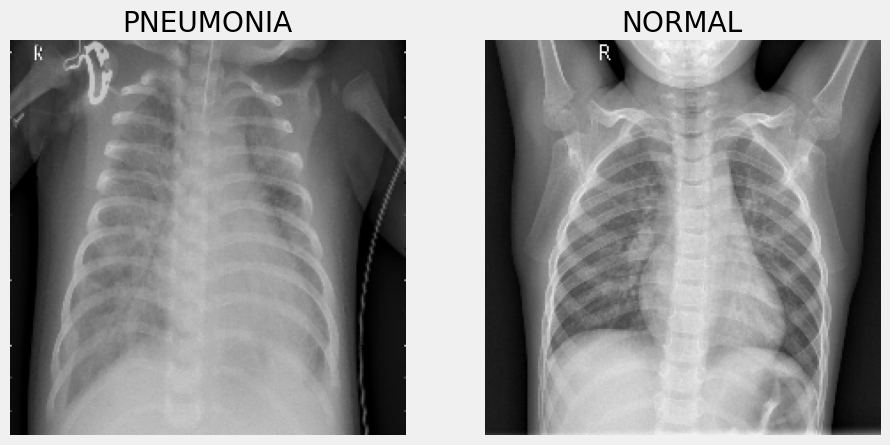

In [8]:
import matplotlib.pyplot as plt

labels = ['PNEUMONIA', 'NORMAL']

# Find the index of an image with PNEUMONIA label
pneumonia_index = np.where(train_labels == 0)[0][0]

# Find the index of an image with NORMAL label
normal_index = np.where(train_labels == 1)[0][0]

# Create a figure with 1 row and 2 columns for the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the image with PNEUMONIA label
axes[0].imshow(train_images[pneumonia_index], cmap='gray')
axes[0].axis('off')
axes[0].set_title(labels[train_labels[pneumonia_index]])

# Display the image with NORMAL label
axes[1].imshow(train_images[normal_index], cmap='gray')
axes[1].axis('off')
axes[1].set_title(labels[train_labels[normal_index]])

plt.show()


In [9]:
# Initialize empty lists for features (X) and labels (y)
X_list = []
y_list = []

# For train data
for feature, label in zip(train_images, train_labels):
    X_list.append(feature)
    y_list.append(label)

# For test data
for feature, label in zip(test_images, test_labels):
    X_list.append(feature)
    y_list.append(label)
    
# For validation data
for feature, label in zip(val_images, val_labels):
    X_list.append(feature)
    y_list.append(label)

# Convert lists to numpy arrays
X = np.array(X_list)
y = np.array(y_list)

# Reshape data for deep learning
X = X.reshape(-1, img_size, img_size, 3)  # Ensure correct number of channels (RGB)

# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)


In [10]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

Data Augmentation

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

Model Construction

In [12]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your own classification layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(512, activation='relu')(x)  # Fully connected layer
predictions = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base VGG16 model
for layer in base_model.layers:
    layer.trainable = False





Model Compilation

In [13]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


Model Summary

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2,
verbose=1,factor=0.3, min_lr=0.000001) 

Model Training

In [16]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 20 , validation_data =
datagen.flow(X_val, y_val) ,callbacks = [learning_rate_reduction]) 


Epoch 1/20


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 1096s 9s/step - accuracy: 0.7552 - loss: 0.4924 - val_accuracy: 0.8719 - val_loss: 0.2910 - learning_rate: 0.0010
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1065s 9s/step - accuracy: 0.8566 - loss: 0.3224 - val_accuracy: 0.8709 - val_loss: 0.3145 - learning_rate: 0.0010
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1067s 9s/step - accuracy: 0.8687 - loss: 0.2931 - val_accuracy: 0.9007 - val_loss: 0.2417 - learning_rate: 0.0010
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1067s 9s/step - accuracy: 0.8737 - loss: 0.2817 - val_accuracy: 0.8645 - val_loss: 0.2819 - learning_rate: 0.0010
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1066s 9s/step - accuracy: 0.8842 - loss: 0.2816 - val_accuracy: 0.9242 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1068s 9s/step - accuracy: 0.8844 - loss: 0.2759 - val_accuracy: 0.9018 - val_loss: 0.2426 - learning_rate: 0.0010
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8859 - loss: 0.2728
Ep

Model Evaluation

In [17]:
model.evaluate(X_test, y_test)


37/37 ━━━━━━━━━━━━━━━━━━━━ 264s 7s/step - accuracy: 0.9127 - loss: 0.2170


[0.22824320197105408, 0.9095563292503357]

Model Accuracy

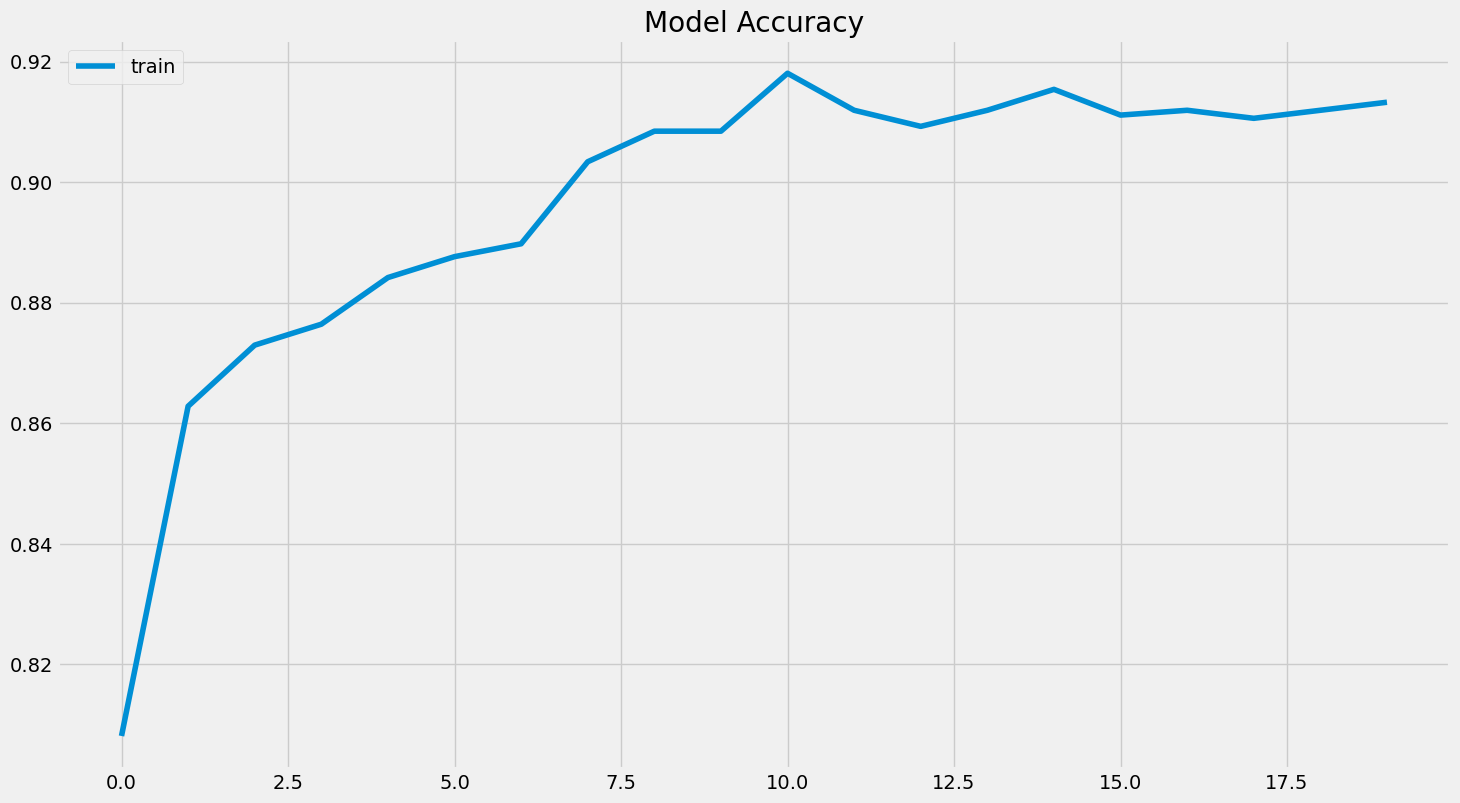

In [19]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['accuracy'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()



Model Loss

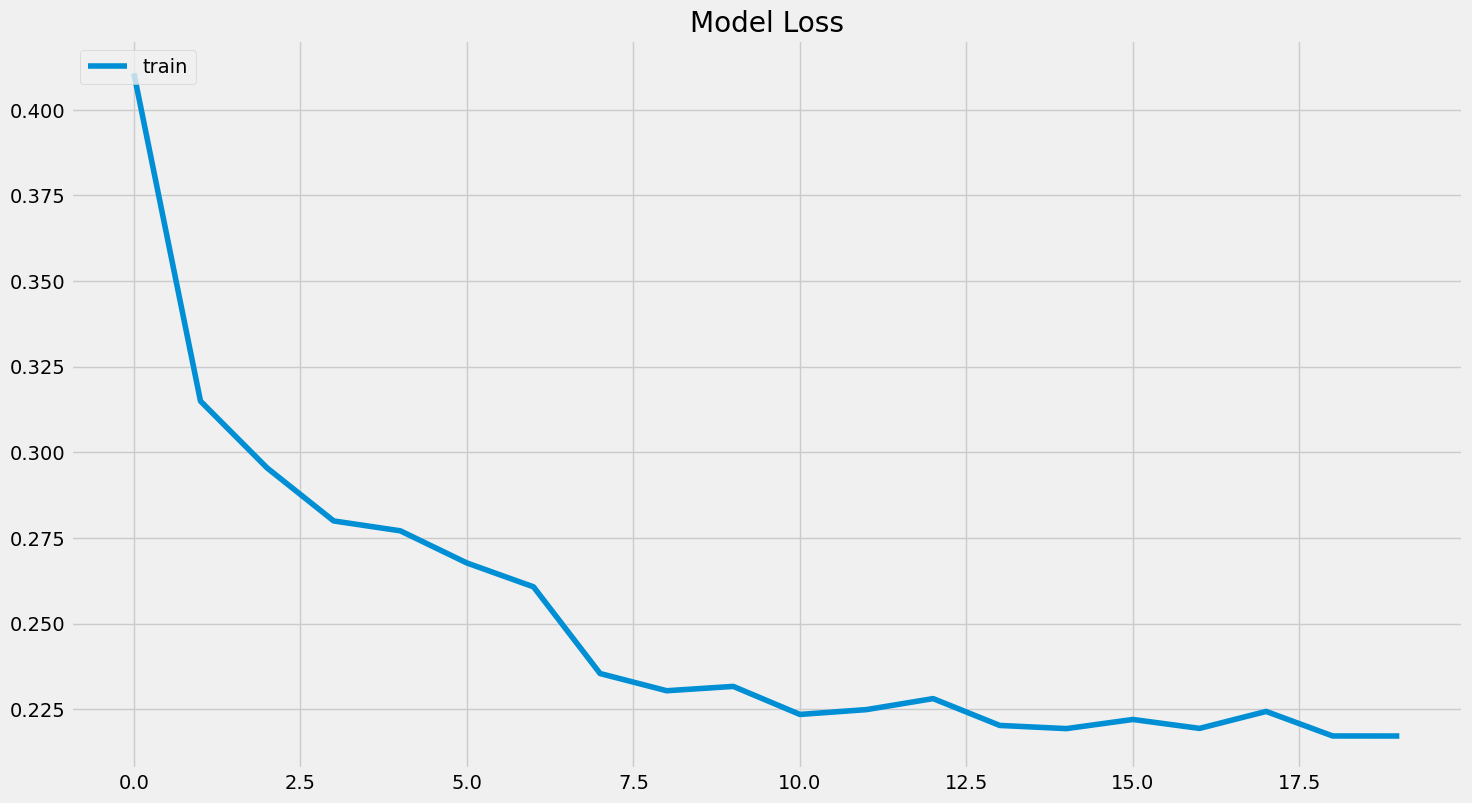

In [20]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()



Model Validation Accuracy

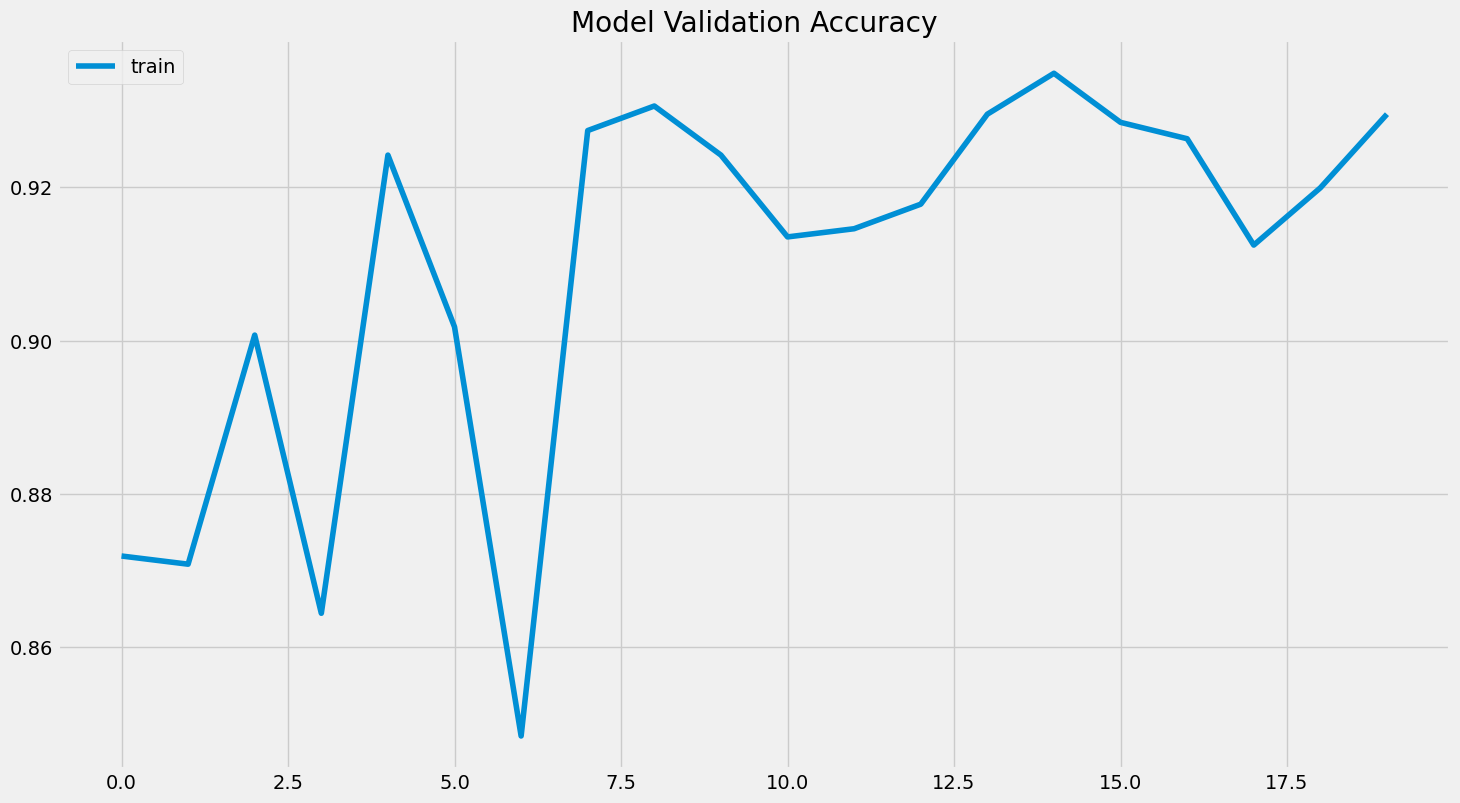

In [21]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()



Model Validation Loss

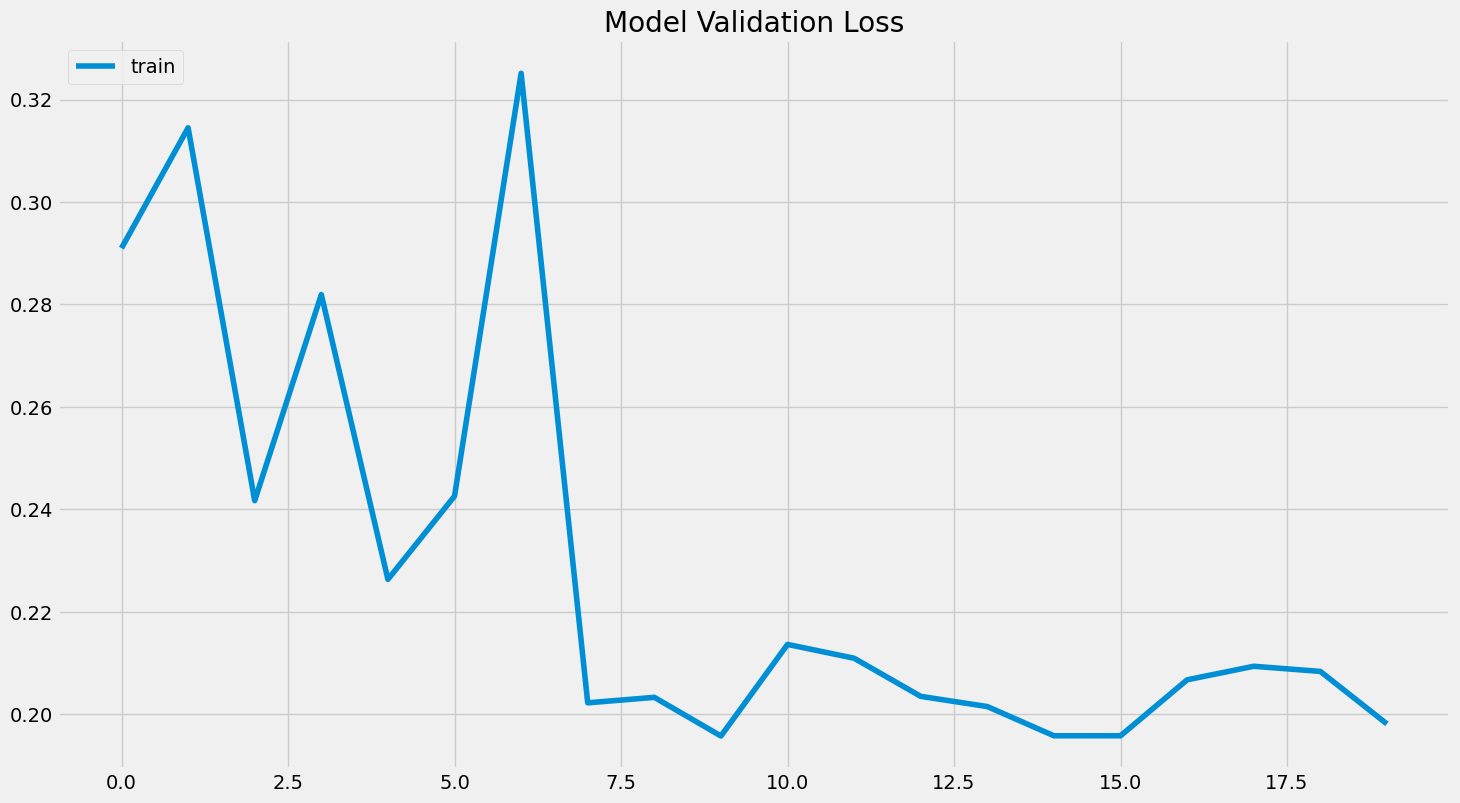

In [22]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [23]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 ━━━━━━━━━━━━━━━━━━━━ 882s 7s/step


Precision vs Recall

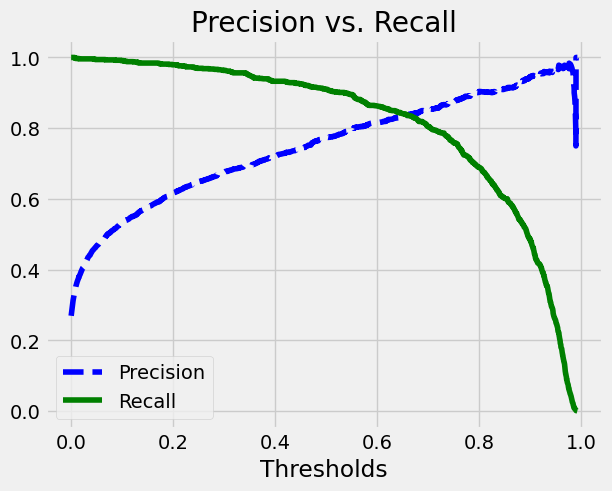

In [25]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()


plot_precision_recall(precisions, recalls, thresholds)



False Positive Rate vs True Positive Rate

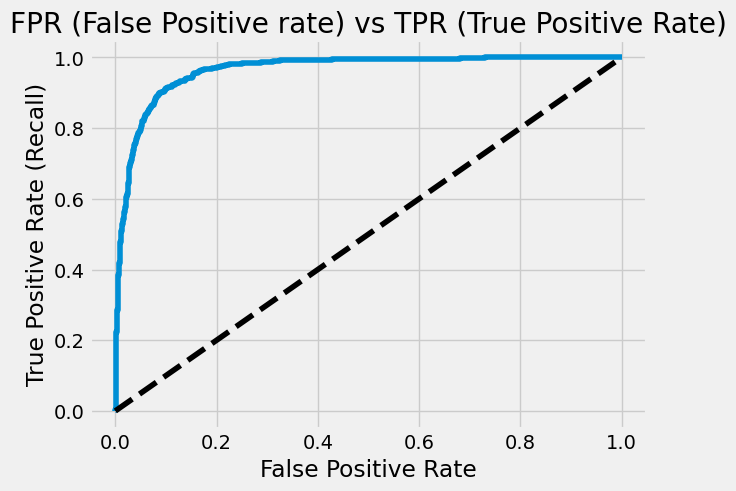

In [26]:
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
plot_roc(fpr, tpr)

In [27]:
predictions = model.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 279s 7s/step


In [28]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

Accuracy , Precision and Recall

In [29]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9172354948805461
Precision on testing set: 0.9209726443768997
Recall on testing set: 0.8101604278074866


Confusion Matrix

[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

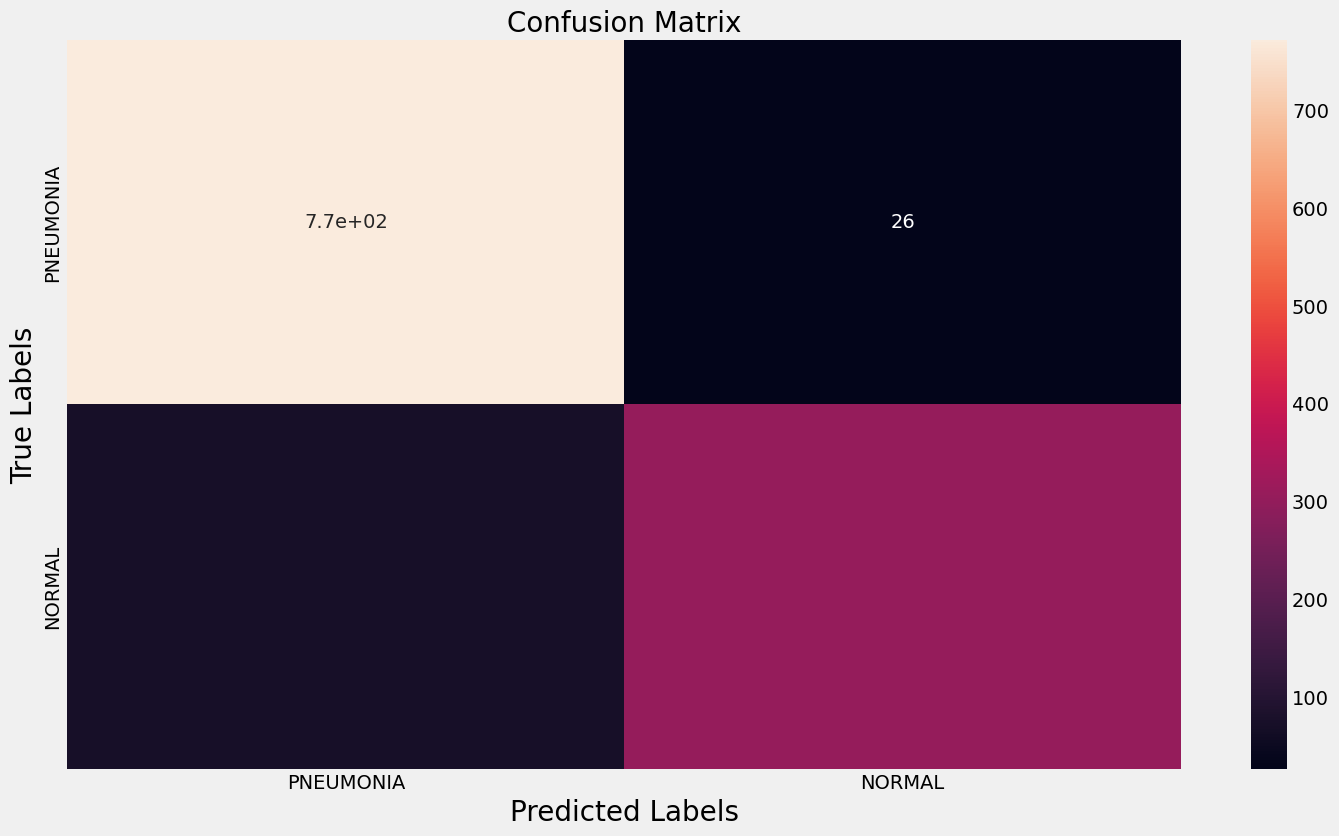

In [30]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

Sample Output

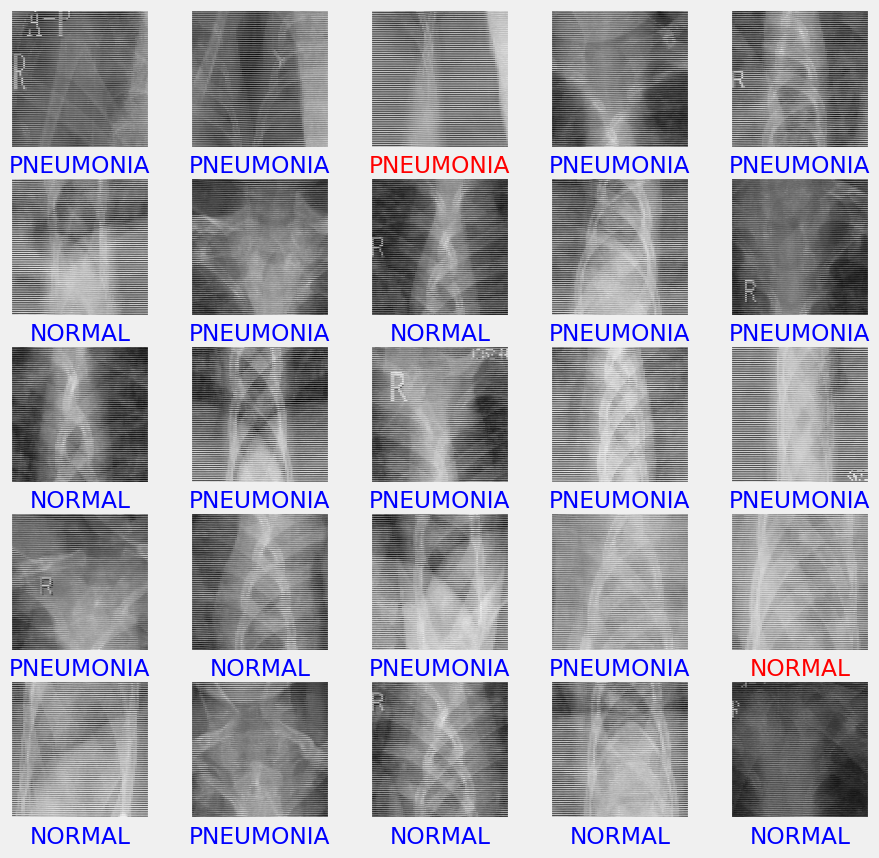

In [31]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

In [32]:
model.save("C:/Users/Dell/Desktop/my-model/model.h5")